In [2]:
import modisco
import h5py
import intervaltree
from collections import defaultdict, OrderedDict, Counter
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import modisco
from modisco.visualization import viz_sequence
import tqdm

In [3]:
!pip freeze | grep modisco

modisco==0.5.14.0


In [4]:
import os

In [5]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

## Load Transient MoDISco

In [6]:
# hdf5_results = h5py.File("results_cluster_idx14_peak_set_idx8.hdf5","r")
transient_hdf5_results = h5py.File("./modisco_runs/results_cluster_idx4_gc_neg_peak_set_8_10_11_13/modisco.hdf5","r")
# hdf5_results = h5py.File("/users/surag/modisco_results_allChroms_counts.hdf5","r")

In [7]:
TRANS_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx4/interpretation/2021-04-15_23_54_09/counts_scores.h5"
TRANS_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx4/interpretation/2021-04-15_23_54_09/peaks_valid_scores.bed"

In [8]:
# will crop to this region around center (summit of peak) [this is what was done for this data when modisco was called]
TRANS_CROP = 500

In [9]:
transient_scores = h5py.File(TRANS_HDF5_PATH, 'r')

In [10]:
# scores.close()

In [11]:
with open(TRANS_REG_PATH) as f:
    scores_regions = [x.strip().split('\t') for x in f]

# importance scores are computed centered at summit (2nd col + 10th col)
scores_regions = [(x[0], int(x[9])+int(x[1])-TRANS_CROP//2, int(x[9])+int(x[1])+TRANS_CROP//2) for x in scores_regions]

In [12]:
PEAK_SET_BASE = "../20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx{}.bed"
# PEAK_SET = "./peak_sets/open_stay.200.bed"

In [13]:
peak_set_intervals = defaultdict(intervaltree.IntervalTree)

PEAK_SET_SELECT = [8,10,11,13] # same as peak sets in hdf5_results file name
for peak_set_idx in PEAK_SET_SELECT:
    with open(PEAK_SET_BASE.format(peak_set_idx)) as f:
        for i,x in enumerate(f):
            x = x.strip().split('\t')
            peak_set_intervals[x[0]][int(x[1]):int(x[2])] = peak_set_idx

Below steps were done to subselect peaks before running MoDISco

In [14]:
# find scored regions intersecting with peak set

intersecting_idx = [i for i,x in enumerate(scores_regions) if peak_set_intervals[x[0]][x[1]:x[2]]]

print(sum([len(peak_set_intervals[x]) for x in peak_set_intervals]))
print(len(intersecting_idx))
print(len(scores_regions))

81944
61748
166037


In [15]:
intersecting_peak_set = [peak_set_intervals[scores_regions[i][0]][scores_regions[i][1]:scores_regions[i][2]] for i in intersecting_idx]
intersecting_peak_set = [list(x)[0].data for x in intersecting_peak_set]

In [16]:
Counter(intersecting_peak_set)

Counter({8: 22662, 13: 6391, 11: 15213, 10: 17482})

In [17]:
def revcomp(x):
    # Assuming ACGT
    return x[::-1][:,::-1]

In [18]:
TRANS_CENTER = int(transient_scores['shap']['seq'].shape[-1]/2)
TRANS_CROP_START = TRANS_CENTER - TRANS_CROP//2
TRANS_CROP_END = TRANS_CENTER + TRANS_CROP//2

In [19]:
PAT = "pattern_0"
trans_pat = transient_hdf5_results['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns'][PAT]

In [20]:
idxs = trans_pat['seqlets_and_alnmts']['seqlets']
idxs = [int(x.decode().split(',')[0].split(":")[1]) for x in idxs]
seqlet_to_peak_idxs = [intersecting_peak_set[x] for x in idxs]

In [21]:
emb = trans_pat["twod_embedding"]
sc = trans_pat["subclusters"]

No handles with labels found to put in legend.


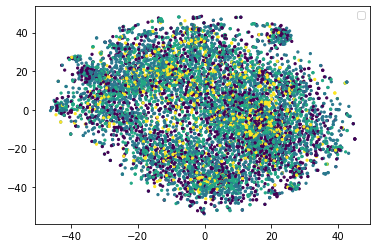

In [22]:
plt.scatter(emb[:,0], emb[:,1], c=np.array(seqlet_to_peak_idxs), s=5)
plt.legend()

In [23]:
FWD_START = 8
FWD_END = 23

# OS: 8-23
# K: 15-25
# S: 13-26
# AP1: 16-25

In [24]:
transient_scores['projected_shap']['seq']

<HDF5 dataset "seq": shape (166037, 4, 2346), type "<f8">

In [25]:
TRANS_SEQLET_LEN = trans_pat["sequence"]["fwd"].shape[0]
TRANS_SEQLET_LEN

30

In [26]:
len(trans_pat['seqlets_and_alnmts']['seqlets'])

7291

In [27]:
transient_instances = []
transient_one_hots = []

for i in tqdm.trange(len(trans_pat['seqlets_and_alnmts']['seqlets'])):
#     x = hdf5_results['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets'][i]
    x = trans_pat['seqlets_and_alnmts']['seqlets'][i]
    idx = int(x.decode('utf8').split(',')[0].split(':')[1])
    start = int(x.decode('utf8').split(',')[1].split(':')[1])
    rc = eval(x.decode('utf8').split(',')[3].split(':')[1])
    
    reg = scores_regions[intersecting_idx[idx]]
#     print(reg[0], reg[1]+start, reg[1]+start+30)
    
    cur_proj_shap_scores = transient_scores['projected_shap']['seq'][intersecting_idx[idx]][:, TRANS_CROP_START:TRANS_CROP_END].transpose()
    cur_one_hot = transient_scores['raw']['seq'][intersecting_idx[idx]][:, TRANS_CROP_START:TRANS_CROP_END].transpose()
    
    if rc:
        transient_instances.append(revcomp(cur_proj_shap_scores[start+(TRANS_SEQLET_LEN-FWD_END):start+(TRANS_SEQLET_LEN-FWD_START)]))
        transient_one_hots.append(revcomp(cur_one_hot[start+(TRANS_SEQLET_LEN-FWD_END):start+(TRANS_SEQLET_LEN-FWD_START)]))
    else:
        transient_instances.append(cur_proj_shap_scores[start+FWD_START:start+FWD_END])
        transient_one_hots.append(cur_one_hot[start+FWD_START:start+FWD_END])
        
# RC-ing all instances
transient_instances = np.array(transient_instances)[:,::-1,::-1]
transient_one_hots = np.array(transient_one_hots)[:,::-1,::-1]

100%|██████████| 7291/7291 [02:13<00:00, 54.63it/s] 


In [28]:
transient_instances.shape

(7291, 15, 4)

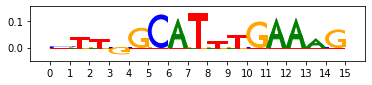

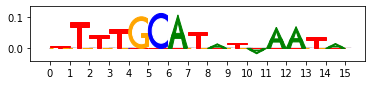

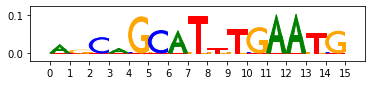

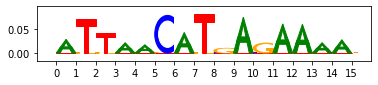

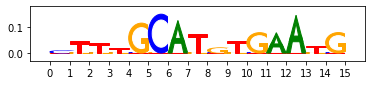

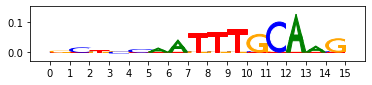

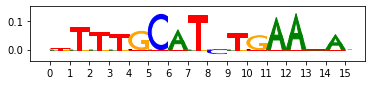

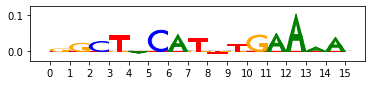

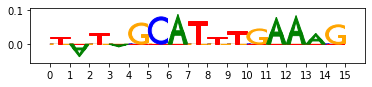

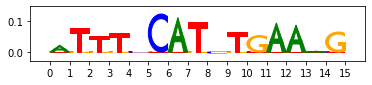

In [29]:
for i in range(10): 
    viz_sequence.plot_weights(transient_instances[i], figsize=(6,1))

## Load iPSC data

In [30]:
ipsc_hdf5_results = h5py.File("/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx16/modisco_2kb_50k/modisco_results_allChroms_counts.hdf5","r")

In [31]:
IPSC_HDF5_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx16/interpretation/2021-04-16_11_07_07/counts_scores.h5"
IPSC_REG_PATH = "/users/surag/oak/projects/scATAC-reprog/bpnet/models/20210414_gc_neg_filt256_in2346_out2000/cluster_idx16/interpretation/2021-04-16_11_07_07/peaks_valid_scores.bed"

In [32]:
ipsc_scores = h5py.File(IPSC_HDF5_PATH, 'r')

In [33]:
PAT = "pattern_1"
ipsc_pat = ipsc_hdf5_results['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns'][PAT]

In [34]:
idxs = ipsc_pat['seqlets_and_alnmts']['seqlets']
idxs = [int(x.decode().split(',')[0].split(":")[1]) for x in idxs]

In [35]:
idxs[:10]

[8577, 10985, 58879, 54480, 53701, 5959, 55039, 54333, 57497, 12692]

In [36]:
FWD_START = 8
FWD_END = 23

# make sure they align with transient instances

In [37]:
ipsc_scores['projected_shap']['seq']

<HDF5 dataset "seq": shape (163182, 4, 2346), type "<f8">

In [38]:
IPSC_SEQLET_LEN = ipsc_pat["sequence"]["fwd"].shape[0]
IPSC_SEQLET_LEN

30

In [39]:
# will crop to this region around center (summit of peak) [this is what was done for this data when modisco was called (Zahoor's method)]
IPSC_CROP = 400

In [40]:
IPSC_CENTER = int(ipsc_scores['shap']['seq'].shape[-1]/2)
IPSC_CROP_START = IPSC_CENTER - IPSC_CROP//2
IPSC_CROP_END = IPSC_CENTER + IPSC_CROP//2

In [41]:
ipsc_instances = []
ipsc_one_hots = []

for i in tqdm.trange(len(ipsc_pat['seqlets_and_alnmts']['seqlets'])):
#     x = hdf5_results['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets'][i]
    x = ipsc_pat['seqlets_and_alnmts']['seqlets'][i]
    idx = int(x.decode('utf8').split(',')[0].split(':')[1])
    start = int(x.decode('utf8').split(',')[1].split(':')[1])
    rc = eval(x.decode('utf8').split(',')[3].split(':')[1])
    
    cur_proj_shap_scores = ipsc_scores['projected_shap']['seq'][idx][:, IPSC_CROP_START:IPSC_CROP_END].transpose()
    cur_one_hot = ipsc_scores['raw']['seq'][idx][:, IPSC_CROP_START:IPSC_CROP_END].transpose()

    if rc:
        ipsc_instances.append(revcomp(cur_proj_shap_scores[start+(IPSC_SEQLET_LEN-FWD_END):start+(IPSC_SEQLET_LEN-FWD_START)]))
        ipsc_one_hots.append(revcomp(cur_one_hot[start+(IPSC_SEQLET_LEN-FWD_END):start+(IPSC_SEQLET_LEN-FWD_START)]))
    else:
        ipsc_instances.append(cur_proj_shap_scores[start+FWD_START:start+FWD_END])
        ipsc_one_hots.append(cur_one_hot[start+FWD_START:start+FWD_END])
        
ipsc_instances = np.array(ipsc_instances)
ipsc_one_hots = np.array(ipsc_one_hots)

100%|██████████| 3941/3941 [01:15<00:00, 52.38it/s]


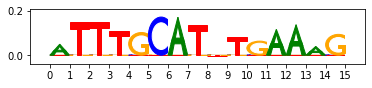

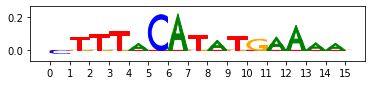

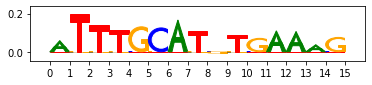

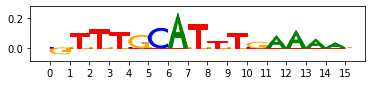

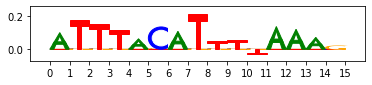

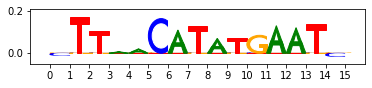

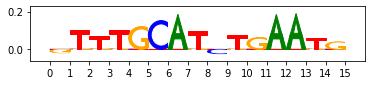

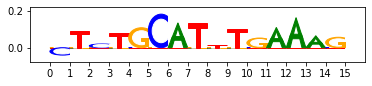

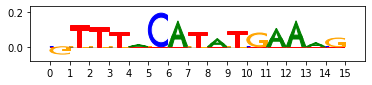

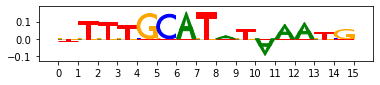

In [42]:
for i in range(10): 
    viz_sequence.plot_weights(ipsc_instances[i], figsize=(6,1))

## Computing log-odds scores and comparing iPSC vs transient

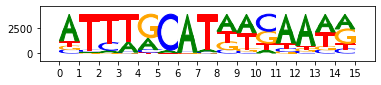

In [187]:
viz_sequence.plot_weights(ipsc_one_hots.sum(0), figsize=(6,1))

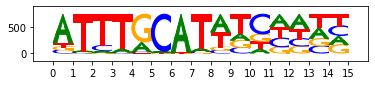

In [197]:
# cluster which is mostly OCT
viz_sequence.plot_weights(ipsc_one_hots[ipsc_pat['subclusters'][:]==2].sum(0), figsize=(6,1))

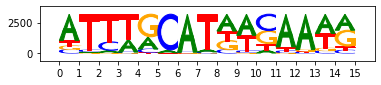

In [188]:
# excluding cluster which is mostly OCT
viz_sequence.plot_weights(ipsc_one_hots[ipsc_pat['subclusters'][:]!=2].sum(0), figsize=(6,1))

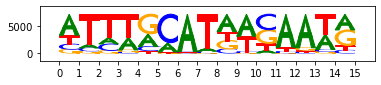

In [191]:
viz_sequence.plot_weights(transient_one_hots.sum(0), figsize=(6,1))

In [84]:
from random import sample, randint, shuffle

In [85]:
logodds_ipsc_one_hot_trans_pwm = []
logodds_trans_one_hot_trans_pwm = []

logodds_ipsc_one_hot_ipsc_pwm = []
logodds_trans_one_hot_ipsc_pwm = []

logodds_ipsc_one_hot_mixed_pwm = []
logodds_trans_one_hot_mixed_pwm = []

In [86]:
ipsc_pwm = ipsc_one_hots.sum(0)
ipsc_pwm = ipsc_pwm/np.sum(ipsc_pwm, axis=1, keepdims=True)
ipsc_logodds_mat = np.log(ipsc_pwm/0.25)

trans_pwm = transient_one_hots.sum(0)
trans_pwm = trans_pwm/np.sum(trans_pwm, axis=1, keepdims=True)
trans_logodds_mat = np.log(trans_pwm/0.25)

# equal weight for both
mixed_pwm = (transient_one_hots.sum(0)/transient_one_hots.shape[0]) + (ipsc_one_hots.sum(0)/ipsc_one_hots.shape[0])
mixed_pwm = mixed_pwm/np.sum(mixed_pwm, axis=1, keepdims=True)
mixed_logodds_mat = np.log(mixed_pwm/0.25)

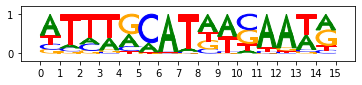

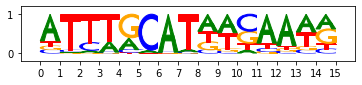

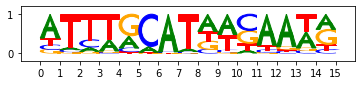

In [87]:
viz_sequence.plot_weights(trans_pwm, figsize=(6,1))
viz_sequence.plot_weights(ipsc_pwm, figsize=(6,1))
viz_sequence.plot_weights(mixed_pwm, figsize=(6,1))

In [88]:
print(np.median(np.sum(transient_one_hots*trans_logodds_mat, axis=(1,2))))
print(np.median(np.sum(transient_one_hots*ipsc_logodds_mat, axis=(1,2))))
print(np.median(np.sum(transient_one_hots*mixed_logodds_mat, axis=(1,2))))

7.910797994114137
7.349504008136046
7.797767006779859


In [89]:
print(np.median(np.sum(ipsc_one_hots*trans_logodds_mat, axis=(1,2))))
print(np.median(np.sum(ipsc_one_hots*ipsc_logodds_mat, axis=(1,2))))
print(np.median(np.sum(ipsc_one_hots*mixed_logodds_mat, axis=(1,2))))

9.028556319612543
9.280404667784344
9.261640552809071


In [230]:
import seaborn as sns

In [231]:
THRESH = 5

to_plot_ipsc = np.sum(ipsc_one_hots*mixed_logodds_mat, axis=(1,2))
to_plot_ipsc = to_plot_ipsc[to_plot_ipsc>THRESH]

to_plot_trans = np.sum(transient_one_hots*mixed_logodds_mat, axis=(1,2))
to_plot_trans = to_plot_trans[to_plot_trans>THRESH]

In [232]:
np.median(to_plot_ipsc), np.median(to_plot_trans)

(9.559104644937237, 8.093256929391742)

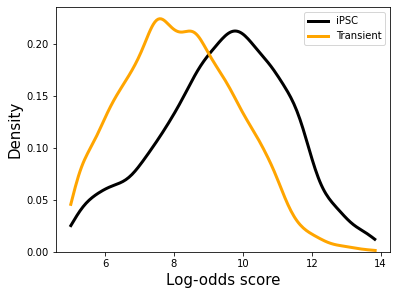

In [244]:
sns.kdeplot(to_plot_ipsc, label='iPSC', cut=0, c='k', linewidth=3)
sns.kdeplot(to_plot_trans, label='Transient', cut=0, c='orange', linewidth=3)
plt.xlabel("Log-odds score", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.legend()
plt.savefig("tmp.pdf")
# pd.Series(logodds_p11).hist(bins=50,alpha=0.5)

Text(0, 0.5, 'Log-odds')

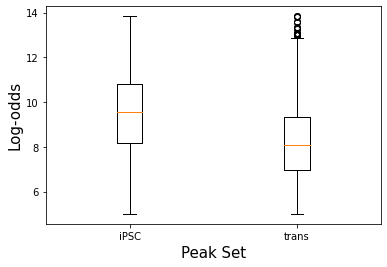

In [252]:
plt.boxplot([to_plot_ipsc,to_plot_trans],
            labels=["iPSC","trans"])
plt.xlabel("Peak Set", fontsize=15)
plt.ylabel("Log-odds", fontsize=15)
# plt.show()
# plt.savefig("tmp.pdf")

In [253]:
import scipy
print(scipy.stats.mannwhitneyu(to_plot_trans, to_plot_ipsc)[1])

1.0638441765790248e-220


## Matrix of instances

In [358]:
# same as R
cmap = sns.color_palette(['#109648', '#255C99', '#F7B32B', '#D62839']) 
cmap

[(0.06274509803921569, 0.5882352941176471, 0.2823529411764706),
 (0.1450980392156863, 0.3607843137254902, 0.6),
 (0.9686274509803922, 0.7019607843137254, 0.16862745098039217),
 (0.8392156862745098, 0.1568627450980392, 0.2235294117647059)]

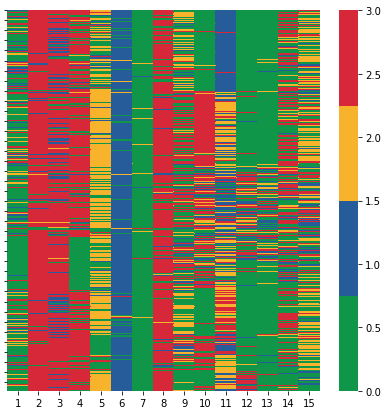

In [359]:
f, ax = plt.subplots(figsize=(7,7))

cur = sns.heatmap(np.argmax(ipsc_one_hots[np.argsort(ipsc_pat['subclusters'][:])], -1), 
                  cmap=cmap, #sns.color_palette(['red', 'green', 'blue', 'black']), 
                  ax=ax)
cur.set(xticklabels=range(1,16))
cur.set(yticklabels=[])
plt.show()

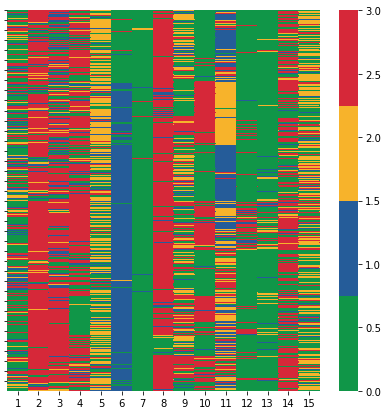

In [360]:
f, ax = plt.subplots(figsize=(7,7))

cur = sns.heatmap(np.argmax(transient_one_hots[np.argsort(trans_pat['subclusters'][:])], -1), 
                  cmap=cmap, #sns.color_palette(['red', 'green', 'blue', 'black']), 
                  ax=ax)
cur.set(xticklabels=range(1,16))
cur.set(yticklabels=[])
plt.show()

### UMAP

In [47]:
import umap

In [75]:
transient_one_hots.shape

(7291, 15, 4)

In [77]:
ipsc_one_hots.shape

(3941, 15, 4)

In [79]:
np.random.permutation(5)

array([0, 4, 3, 2, 1])

In [209]:
# remove cluster of OCT only
ipsc_one_hots_oct_only = ipsc_one_hots[ipsc_pat['subclusters'][:]!=2]

In [210]:
ipsc_one_hots_oct_only.shape

(3200, 15, 4)

In [211]:
# subsample equal number of transient
subsamp_transient_one_hots = transient_one_hots[np.random.permutation(transient_one_hots.shape[0])[:ipsc_one_hots_oct_only.shape[0]]]
subsamp_transient_one_hots.shape

(3200, 15, 4)

In [212]:
umap_reducer = umap.UMAP(metric='hamming')

In [213]:
to_emb = np.vstack([subsamp_transient_one_hots.reshape((-1, 60)),
               ipsc_one_hots_oct_only.reshape((-1, 60))])
emb = umap_reducer.fit_transform(to_emb)

/users/surag/anaconda3/envs/mtbatchgen/lib/python3.7/site-packages/umap/umap_.py:1762: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


In [214]:
emb.shape

(6400, 2)

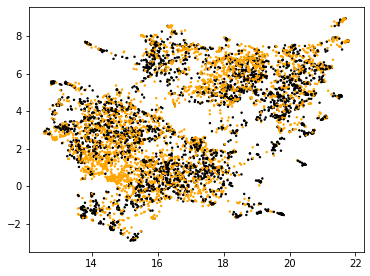

In [215]:
shuf_order = np.random.permutation(emb.shape[0])

plt.rcParams["figure.figsize"] = (6,4.5)
plt.scatter(emb[:,0][shuf_order], emb[:,1][shuf_order], 
            s=2,
           c=np.array(['orange']*subsamp_transient_one_hots.shape[0] + 
                      ['k']*ipsc_one_hots_oct_only.shape[0])[shuf_order])

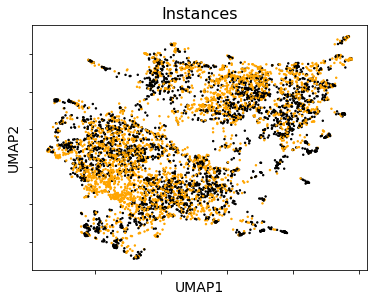

In [219]:
# this is a placeholder plot, make final in R/ggplot
shuf_order = np.random.permutation(emb.shape[0])

plt.rcParams["figure.figsize"] = (6,4.5)
plt.scatter(emb[:,0][shuf_order], emb[:,1][shuf_order], 
            s=2,
           c=np.array(['orange']*subsamp_transient_one_hots.shape[0] + 
                      ['k']*ipsc_one_hots_oct_only.shape[0])[shuf_order])
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
# plt.xticks([])
# plt.yticks([])
plt.title("Instances", fontsize=16)
plt.xlabel("UMAP1", fontsize=14)
plt.ylabel("UMAP2", fontsize=14)
# plt.savefig("tmp.pdf")

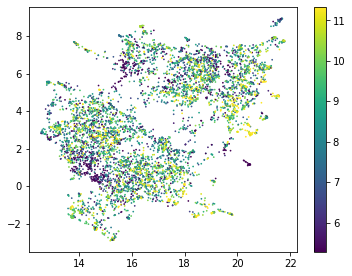

In [225]:
cur_logodds = np.sum(to_emb*mixed_logodds_mat.reshape((-1,60)), axis=-1)

plt.scatter(emb[:,0], emb[:,1], 
            s=0.5,
           c=cur_logodds,
           cmap='viridis',
           vmin=np.quantile(cur_logodds,0.1),
           vmax=np.quantile(cur_logodds,0.9))
plt.colorbar()

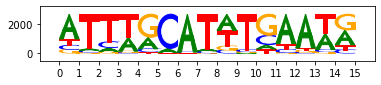

In [223]:
viz_sequence.plot_weights(to_emb.reshape((-1,15,4))[(4*emb[:,0]+3*emb[:,1])>80].sum(0), figsize=(6,1))
# viz_sequence.plot_weights(ipsc_pwm, figsize=(6,1))
# viz_sequence.plot_weights(mixed_pwm, figsize=(6,1))

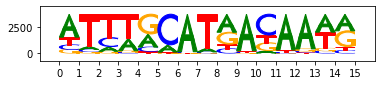

In [224]:
viz_sequence.plot_weights(to_emb.reshape((-1,15,4))[(4*emb[:,0]+3*emb[:,1])<80].sum(0), figsize=(6,1))
# viz_sequence.plot_weights(ipsc_pwm, figsize=(6,1))
# viz_sequence.plot_weights(mixed_pwm, figsize=(6,1))

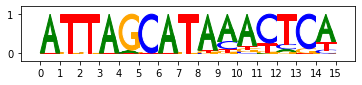

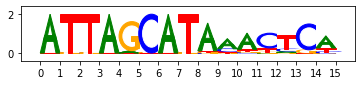

In [228]:
cur_mot = to_emb.reshape((-1,15,4))[(emb[:,0]< 22)&(emb[:,0]>20)&(emb[:,1]> 0)&(emb[:,1]< 2)].sum(0)
cur_mot /= np.sum(cur_mot, axis=1, keepdims=True)

viz_sequence.plot_weights(cur_mot, 
                          figsize=(6,1))

viz_sequence.plot_weights(viz_sequence.ic_scale(cur_mot, background=[0.25]*4),  
                          figsize=(6,1))